In [1447]:
import networkx as nx
import pprint
import random
import matplotlib.pyplot as plt
import numpy as np

In [1448]:
def generate_exchange_matrix(size: int, graph: nx.Graph) -> list:
    """計算機間の通信コストを表す交流行列を作成する
        通信コストはランダムに決定する
    Args:
        size (int): 行列のサイズ(計算機の数) (size x size).
        graph (nx.Graph): ネットワークトポロジのグラフ表現.

    Returns:
        list: 交流行列
    """
    adj_list = nx.to_dict_of_lists(graph)
    matrix = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            if i == j:
                matrix[i][j] = 0
            elif j in adj_list[i]:
                matrix[i][j] = random.randint(1, 100)
                matrix[j][i] = matrix[i][j]  # Set symmetric element
            else:
                matrix[i][j] = -1

    for i in range(size):
        for j in range(size):
            if j in adj_list[i]:
                graph.add_edge(i, j, weight=matrix[i][j])

    return matrix

In [1449]:
def generate_random_graph(num_nodes: int) -> nx.Graph:
    """ランダムなネットワークトポロジーのグラフを作成する

    Args:
        num_nodes (int): ノードの数(計算機の数)

    Returns:
        nx.Graph: ネットワークトポロジーを表すグラフ
    """
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    for i in range(num_nodes):
        G.add_edge(i, (i + 1) % num_nodes)

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if random.random() < 0.5:
                G.add_edge(i, j)

    return G


In [1450]:
def weightintg_graph(graph: nx.Graph, exchange_matrix: list):
    """交流行列からネットワークトポロジーのグラフに重み(通信コスト)を付ける

    Args:
        graph (nx.Graph): トポロジーを表すグラフ
        exchange_matrix (list): 計算期間の通信コストを表す交流行列
    """
    num_nodes = len(exchange_matrix)
    adj_list = nx.to_dict_of_lists(graph)

    for i in range(num_nodes):
        for j in range(num_nodes):
            if j in adj_list[i]:
                graph.add_edge(i, j, weight=exchange_matrix[i][j])

In [1451]:
def create_block_matrix(num_rows: int, num_cols: int) -> list:
    """ニューラルネットワークを分割したブロックの接続関係を表す行列を作成

    Args:
        num_rows (int): 分割ブロックの行数
        num_cols (int): 分割ブロックの列数

    Returns:
        list: ブロック間の接続を表す行列
        
    Example:
        num_rows = 2, num_cols = 3の場合
        -----
        1 3 5
        2 4 6
        -----
        
        となり接続関係は以下のようになる
        接続関係を持っていれば1, なければ0
        --------------------
        [[0, 1, 1, 1, 0, 0],
        [1, 0, 1, 1, 0, 0],
        [1, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 1],
        [0, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 1, 0]]
        --------------------
    """
    matrix_size = num_rows * num_cols
    matrix = [[0] * matrix_size for _ in range(matrix_size)]

    # Helper function to check if a block is within the matrix bounds
    def is_valid_block(row, col):
        return 0 <= row < num_rows and 0 <= col < num_cols

    # Iterate over each block in depth-first order
    for block in range(matrix_size):
        col = block // num_rows
        row = block % num_rows

        # Connect to vertical neighbors
        if is_valid_block(row - 1, col):
            neighbor = (col * num_rows) + (row - 1)
            matrix[block][neighbor] = 1
            matrix[neighbor][block] = 1
        if is_valid_block(row + 1, col):
            neighbor = (col * num_rows) + (row + 1)
            matrix[block][neighbor] = 1
            matrix[neighbor][block] = 1

        # Connect to horizontal neighbors
        if is_valid_block(row, col - 1):
            neighbor = ((col - 1) * num_rows) + row
            matrix[block][neighbor] = 1
            matrix[neighbor][block] = 1
        if is_valid_block(row, col + 1):
            neighbor = ((col + 1) * num_rows) + row
            matrix[block][neighbor] = 1
            matrix[neighbor][block] = 1

        # Connect to diagonal neighbors
        if is_valid_block(row - 1, col - 1):
            diagonal_neighbor = ((col - 1) * num_rows) + (row - 1)
            matrix[block][diagonal_neighbor] = 1
            matrix[diagonal_neighbor][block] = 1
        if is_valid_block(row - 1, col + 1):
            diagonal_neighbor = ((col + 1) * num_rows) + (row - 1)
            matrix[block][diagonal_neighbor] = 1
            matrix[diagonal_neighbor][block] = 1
        if is_valid_block(row + 1, col - 1):
            diagonal_neighbor = ((col - 1) * num_rows) + (row + 1)
            matrix[block][diagonal_neighbor] = 1
            matrix[diagonal_neighbor][block] = 1
        if is_valid_block(row + 1, col + 1):
            diagonal_neighbor = ((col + 1) * num_rows) + (row + 1)
            matrix[block][diagonal_neighbor] = 1
            matrix[diagonal_neighbor][block] = 1

    return matrix


In [1452]:
def generate_block_list(num_blocks: int) -> list:
    """分割したブロックの番号リスト

    Args:
        num_nodes (int): 分割ブロックの数

    Returns:
        list: ブロックの番号リスト
        
    Example:
        num_blocks = 6の場合
        ------------------
        [0, 1, 2, 3, 4, 5]
        ------------------
    """    
    block_list = []
    for i in range(num_blocks):
        block_list.append(i)
    return block_list

In [1453]:
def generate_assignment_matrix(num_pcs: int, num_blocks: int) -> list:
    values = []
    base_counts = num_blocks // num_pcs  # 基準となる個数
    remaining = num_blocks % num_pcs  # 残りの個数

    # 基準となる個数での乱数生成
    for pc in range(num_pcs):
        values.extend([pc] * base_counts)

    # 残りの個数を等しい比率で乱数生成
    remaining_values = random.choices(range(num_pcs), k=remaining)
    values.extend(remaining_values)

    # 乱数をシャッフル
    random.shuffle(values)

    return values

In [1454]:
def get_pc_by_block_label(block_label: int, assigned_matrix: list) -> int:
    """ブロックのラベルから担当する計算機の番号を返す

    Args:
        block_label (int): ブロックのラベル
        task_matrix (list): 計算機が担当するブロックを表す行列

    Returns:
        int: 計算機の番号
    """
    pc_num = len(assigned_matrix)
    for i in range(pc_num):
        if i == block_label:
            return assigned_matrix[i]
    

In [1455]:
def get_tasks_by_pc(pc: int, assigned_matrix: list) -> int:
    """計算機の番号から担当するブロックのラベルを返す

    Args:
        block_label (int): ブロックのラベル
        assigned_matrix (list): 計算機が担当するブロックを表す行列

    Returns:
        int: ブロックのラベル
    """
    tasks = []
    for i in range(len(assigned_matrix)):
        if pc == assigned_matrix[i]:
            tasks.append(i)
    return tasks

In [1456]:
# def get_linked_blocks(block_label: int, block_linked_matrix: list) -> list:
#     """ブロックのラベルから接続しているブロックのラベルのリストを返す

#     Args:
#         block_labe (int): ブロックのラベル
#         matrix (list): 接続関係を持つ行列

#     Returns:
#         list: 接続しているブロックのラベルのリスト
#     """
#     linked_blocks = []
#     for i in range(len(block_linked_matrix)):
#         if block_linked_matrix[block_label][i] == 1:
#             linked_blocks.append(i)
#     return linked_blocks

In [1457]:
def generate_linked_block_list(matrix: list) -> list:
    """接続しているブロック(結果を送信する必要のある)のラベルのリストを返す

    Args:
        matrix (list): ブロックの配置を表す行列

    Returns:
        list: 各ブロックが結果を送信する必要のあるブロック
        
    Example:
        output:
            B = [[1, 2, 3], [0, 2, 3], [3, 4, 5], [2, 4, 5], [5], [4]]
            
        B[0] = [1, 2, 3]
        ブロック0はブロック1, 2, 3に結果を送信する必要がある
    """
    result = []
    n_cols = matrix.shape[1]

    for j in range(n_cols):
        current_column = matrix[:, j]
        next_column = matrix[:, j + 1] if j < n_cols - 1 else []
        column_elements = [list(set(current_column) - set([current_column[i]])) + list(next_column) for i in range(len(current_column))]
        result.extend(column_elements)
        
    return result

In [1458]:
def evaluate_communication_cost(block_list: list, assigned_matrix: list, linked_blocks: list) -> float:
    """割り当て結果から順伝播させた時の通信コストを計算する

    Args:
        block_list (list): ブロック分割のリスト
        assigned_matrix (list): ニューロンに計算機を割り当てたリスト
        linked_blocks (list): ブロックの接続関係を表すリスト

    Returns:
        float: 総通信コスト
    """    
    total_cost = 0
    for temp_label in block_list:
        # print(temp_label)

        # 始点のPCを取得
        initial_pc = get_pc_by_block_label(block_label=temp_label, assigned_matrix=assigned_matrix)
        # 順伝搬させた時の総通信コストを計算
        # print(f'ブロック{temp_label}を担当するPC: {initial_pc}')
        
        # temp_labelと接続しているブロックのリストを取得
        linked_list = linked_blocks[temp_label]
        # print(f'ブロック{temp_label}と接続しているブロックの番号リスト: {linked_list}')

        # 送信対象のPCを取得
        target_pcs = [get_pc_by_block_label(block_label=linked_block, assigned_matrix=assigned_matrix) for linked_block in linked_list]
        # print(f'ブロック{temp_label}の送信対象のPCの番号リスト: {target_pcs}')

        # 送信対象のPCのリストから重複を削除
        target_pcs = list(set(target_pcs))
        # print(f'ブロック0の送信対象のPCの番号リスト(重複削除後): {target_pcs}')

        # 総通信コストを計算
        temp_cost = 0
        for target in target_pcs:
            path = nx.dijkstra_path(G, 0, target)
            length = nx.dijkstra_path_length(G, 0, target)
            # print(length)
            temp_cost += length
        total_cost += temp_cost
        # print(f'ブロック{temp_label}の総通信コスト: {temp_cost}\n')
    # print(f'総通信コスト: {total_cost}')
    return total_cost

交流行列
[[ 0. 52. -1. 23.]
 [52.  0. 75. -1.]
 [-1. 75.  0. 28.]
 [23. -1. 28.  0.]]

ニューラルネットワークの分割ブロックの接続関係を表す行列
[[1, 2, 3], [0, 2, 3], [3, 4, 5], [2, 4, 5], [5], [4]]

分割ブロックの番号リスト
[0, 1, 2, 3, 4, 5]

PCが担当するブロックの割り当てを表す行列
Group = [0, 1, 2, 2, 3, 0]


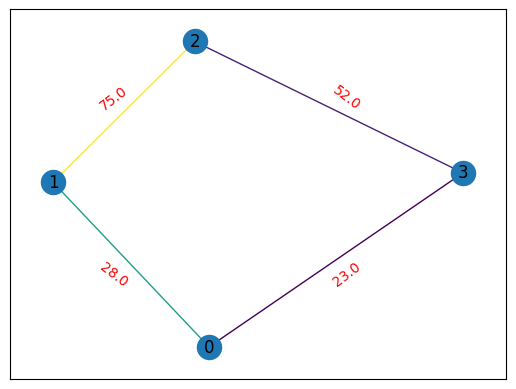

In [1459]:
# ネットワークトポロジーを作成
G = generate_random_graph(4)

# 交流行列を作成
exchange_matrix = generate_exchange_matrix(size=4, graph=G)

# グラフのエッジに通信コスト(交流行列より)を付与
weightintg_graph(G, exchange_matrix)

# グラフの描画
pos = nx.circular_layout(G)
weights = nx.get_edge_attributes(G, 'weight').values()
nx.draw_networkx(G, edge_color = weights)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

# ニューラルネットワークを分割したブロック
block_structure = np.array([[0, 2, 4],
                            [1, 3, 5]])

# 通信する必要のあるブロックのリストを作成
linked_blocks = generate_linked_block_list(block_structure)
num_pcs = 4
num_blocks = 6


print("交流行列")
print(exchange_matrix)

# block_linked_matrix = create_block_matrix(num_rows=2, num_cols=3)
print("\nニューラルネットワークの分割ブロックの接続関係を表す行列")
pprint.pprint(linked_blocks)

block_list = generate_block_list(6)
print("\n分割ブロックの番号リスト")
print(block_list)

# Distribute tasks to computers
assigned_matrix = generate_assignment_matrix(num_pcs, num_blocks)
print("\nPCが担当するブロックの割り当てを表す行列")
print(f'Group = {assigned_matrix}')

In [1460]:
print(f'\n各ブロックが結果を送信する必要のあるブロック:\nB = {linked_blocks}\n')
print(f'ニューロンを担当する計算機:\nG = {assigned_matrix}')
for block_label in range(num_blocks):
    pc = get_pc_by_block_label(block_label, assigned_matrix=assigned_matrix)
    print(f'\nブロック{block_label}を担当するPCの番号: {pc}')
    # linked_blocks = linked_blocks[block_label]
    print(f'ブロック{block_label}の送信対象のブロックの番号リスト: {linked_blocks[block_label]}')


各ブロックが結果を送信する必要のあるブロック:
B = [[1, 2, 3], [0, 2, 3], [3, 4, 5], [2, 4, 5], [5], [4]]

ニューロンを担当する計算機:
G = [0, 1, 2, 2, 3, 0]

ブロック0を担当するPCの番号: 0
ブロック0の送信対象のブロックの番号リスト: [1, 2, 3]

ブロック1を担当するPCの番号: 1
ブロック1の送信対象のブロックの番号リスト: [0, 2, 3]

ブロック2を担当するPCの番号: 2
ブロック2の送信対象のブロックの番号リスト: [3, 4, 5]

ブロック3を担当するPCの番号: 2
ブロック3の送信対象のブロックの番号リスト: [2, 4, 5]

ブロック4を担当するPCの番号: 3
ブロック4の送信対象のブロックの番号リスト: [5]

ブロック5を担当するPCの番号: 0
ブロック5の送信対象のブロックの番号リスト: [4]


In [1461]:

print(f'\n各ブロックが結果を送信する必要のあるブロック:\nB = {linked_blocks}')
print(f'ニューロンを担当する計算機:\nGroup = {assigned_matrix}\n')

total_cost = evaluate_communication_cost(block_list=block_list, linked_blocks=linked_blocks, assigned_matrix=assigned_matrix)
print(f'総通信コスト: {total_cost}')


各ブロックが結果を送信する必要のあるブロック:
B = [[1, 2, 3], [0, 2, 3], [3, 4, 5], [2, 4, 5], [5], [4]]
ニューロンを担当する計算機:
Group = [0, 1, 2, 2, 3, 0]

総通信コスト: 325.0
